In [108]:
import os, sys
currentdir = os.path.dirname(os.path.realpath("__file__"))
parentdir = os.path.dirname(os.path.dirname(os.path.dirname(os.path.realpath("__file__"))))
sys.path.append(parentdir)

from joblib import Parallel, delayed
import numpy as np
import pickle 
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torchmetrics
import seaborn as sns
import glob
import dask.dataframe as dd
from tqdm import tqdm
from copy import deepcopy
from sklearn.metrics import matthews_corrcoef, f1_score, accuracy_score
from pathlib import Path

from torchmetrics import MatthewsCorrCoef, F1Score, Accuracy, Precision, Recall
from sklearn.utils import resample
from scipy.stats import median_abs_deviation as mad
import time
import cmcrameri.cm as cmc
import matplotlib.colors as clr
from matplotlib.ticker import MultipleLocator, LinearLocator, AutoMinorLocator
plt.rcParams["grid.linestyle"] =  ":"
plt.rcParams["axes.edgecolor"] = "gray"
plt.rcParams["axes.linewidth"] = 0.7

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Arial"
#sns.set_context("notebook", font_scale=1.2)
#import scienceplots
#plt.style.use(["science", "nature"])


if Path.home().name == "nikolaibeckjensen":
    DATA_ROOT = Path.home() / "Library" / "CloudStorage" / "OneDrive-DanmarksTekniskeUniversitet" / "Virk2Vec" / "data"
elif Path.home().name == "annabramslow":
    DATA_ROOT = Path.home() / "Library" / "CloudStorage" / "OneDrive-DanmarksTekniskeUniversitet(2)" / "Virk2Vec" / "data"

#### Description
This notebook is used to evaluate the *Mortality* model + breakdown of performance metric by groups.

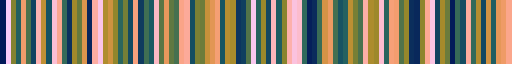

In [109]:
cmap = cmc.batlowS
cmap

In [110]:
v = "4.02"
#v= "6.3"
save_path = r"../analysis/plots/%s/" %v

In [111]:
def load_stats(path):
    data = {}
    with open(path + "prb.npy", "rb") as f:
        data["prb"] = np.load(f).astype(np.float32)
    with open(path + "trg.npy", "rb") as f:
        data["trg"] = np.load(f)
    with open(path + "id.npy", "rb") as f:
        data["id"] = np.load(f)
    return data
def metrics_parallel(metrics, preds, targs):
    return metrics(preds, targs).numpy()

def return_auc(preds, targs):
    metric = torchmetrics.AUROC(num_classes=2)
    return metric(preds, targs).numpy().item()

def return_mcc(preds, targs):
    metric = MatthewsCorrCoef(num_classes=2)
    return metric(preds, targs).numpy().item()

def return_acc(preds, targs):
    metric = Accuracy(num_classes=2, average="macro", multiclass=True)
    return metric(preds, targs).numpy().item()

def return_f1(preds, targs):
    metric = F1Score(num_classes=2, task='binary')
    return metric(preds, targs).numpy().item()

def return_precision(preds, targs):
    metric = Precision(num_classes=2, task='binary')
    return metric(preds, targs).numpy().item()

def return_recall(preds, targs):
    metric = Recall(num_classes=2, task='binary')
    return metric(preds, targs).numpy().item()

def bootstrap_mcc(preds, targs, seed: int = 2021, n_bootstraps: int = 1000, ci: float = 0.05):
    ids = np.arange(0, targs.shape[0], 1)
    metric = MatthewsCorrCoef(num_classes=2,threshold=0.505)
    idx = list()

    for n in range(n_bootstraps):
        i  = resample(ids, stratify=targs.numpy(), random_state=n)
        if len(np.unique(targs[i])) < 2:
                continue
        idx.append(i)

    scores = []
    for i in idx:
        score = metric(preds[i], targs[i])
        scores.append(score)
    scores = np.array(scores)
    
    return {"mean": metric(preds, targs).numpy().item(), "lower": np.quantile(scores, ci /2), "upper": np.quantile(scores, 1-ci/2)}

def bootstrap_precision(preds, targs, seed: int = 2021, n_bootstraps: int = 1000, ci: float = 0.05):
    ids = np.arange(0, targs.shape[0], 1)
    metric = Precision(task='binary')
    idx = list()

    for n in range(n_bootstraps):
        i  = resample(ids, stratify=targs.numpy(), random_state=n)
        if len(np.unique(targs[i])) < 2:
                continue
        idx.append(i)

    scores = []
    for i in idx:
        score = metric(preds[i], targs[i])
        scores.append(score)
    scores = np.array(scores)
    
    return {"mean": metric(preds, targs).numpy().item(), "lower": np.quantile(scores, ci /2), "upper": np.quantile(scores, 1-ci/2)}


def bootstrap_recall(preds, targs, seed: int = 2021, n_bootstraps: int = 1000, ci: float = 0.05):
    ids = np.arange(0, targs.shape[0], 1)
    metric = Recall(task='binary')
    idx = list()

    for n in range(n_bootstraps):
        i  = resample(ids, stratify=targs.numpy(), random_state=n)
        if len(np.unique(targs[i])) < 2:
                continue
        idx.append(i)

    scores = []
    for i in idx:
        score = metric(preds[i], targs[i])
        scores.append(score)
    scores = np.array(scores)
    
    return {"mean": metric(preds, targs).numpy().item(), "lower": np.quantile(scores, ci /2), "upper": np.quantile(scores, 1-ci/2)}


def bootstrap_f1(preds, targs, seed: int = 2021, n_bootstraps: int = 1000, ci: float = 0.05):
    ids = np.arange(0, targs.shape[0], 1)
    metric = F1Score(num_classes=2, task='binary')
    idx = list()

    for n in range(n_bootstraps):
        i  = resample(ids, stratify=targs.numpy(), random_state=n)
        if len(np.unique(targs[i])) < 2:
                continue
        idx.append(i)

    scores = []
    for i in idx:
        score = metric(preds[i], targs[i])
        scores.append(score)
    scores = np.array(scores)
    
    return {"mean": metric(preds, targs).numpy().item(), "lower": np.quantile(scores, ci /2), "upper": np.quantile(scores, 1-ci/2)}

def bootstrap_acc(preds, targs, seed: int = 2021, n_bootstraps: int = 1000, ci: float = 0.05):
    ids = np.arange(0, targs.shape[0], 1)
    metric = Accuracy(task='binary')
    idx = list()

    for n in range(n_bootstraps):
        i  = resample(ids, stratify=targs.numpy(), random_state=n)
        if len(np.unique(targs[i])) < 2:
                continue
        idx.append(i)

    scores = []
    for i in idx:
        score = metric(preds[i], targs[i])
        scores.append(score)
    scores = np.array(scores)
    
    return {"mean": metric(preds, targs).numpy().item(), "lower": np.quantile(scores, ci /2), "upper": np.quantile(scores, 1-ci/2)}

def return_stats(path: str):
    x  = load_stats(path)
    start = time.time()
    x["auc"] = return_auc(preds = torch.from_numpy(x["prb"]),  
              targs = torch.from_numpy(x["trg"]).long()) 

    print("AUC is done: %.2f s" %(time.time()-start))
    print(x["auc"])
    start = time.time()
    x["mcc"] = bootstrap_mcc(preds = torch.from_numpy(x["prb"]),  
              targs = torch.from_numpy(x["trg"]).long(), 
              n_bootstraps=1000)
    print("MCC is done: %.2f s" %(time.time()-start))
    print(x["mcc"])

    start = time.time()
    x["acc"] = bootstrap_acc(preds = torch.from_numpy(x["prb"]),  
              targs = torch.from_numpy(x["trg"]).long(), 
              n_bootstraps=1000)
    print("ACC is done: %.2f s" %(time.time()-start))
    print(x["acc"])

    start = time.time()
    
    x["f1"] = bootstrap_f1(preds = torch.from_numpy(x["prb"]),  
              targs = torch.from_numpy(x["trg"]).long(), 
              n_bootstraps=1000)
    print("F1 is done: %.2f s" %(time.time()-start))
    print(x["f1"])

    start = time.time()
    x["precision"] = bootstrap_precision(preds = torch.from_numpy(x["prb"]),  
              targs = torch.from_numpy(x["trg"]).long(), 
              n_bootstraps=1000)
    print("Precision is done: %.2f s" %(time.time()-start))
    print(x["precision"])

    start = time.time()

    x["recall"] = bootstrap_recall(preds = torch.from_numpy(x["prb"]),  
              targs = torch.from_numpy(x["trg"]).long(), 
              n_bootstraps=1000)
    print("Recall is done: %.2f s" %(time.time()-start))
    print(x["recall"])

    return x

def contains_in_sequence(sample, min_, max_):
    """Checks if sequence contains tokens in range [min_, max_]"""
    return np.where((sample >= min_) & (sample <=max_))[0].shape[0] > 0

In [112]:
bankruptcy_c2v = r"/Users/nikolaibeckjensen/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Virk2Vec/predictions/bankruptcy/company2vec/"
dummy_path = r"/Users/nikolaibeckjensen/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Virk2Vec/predictions/bankruptcy/dummy/"
moving_c2v = r"/Users/nikolaibeckjensen/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Virk2Vec/predictions/moving/company2vec/"
moving_dummy = r"/Users/nikolaibeckjensen/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Virk2Vec/predictions/moving/dummy/"

In [33]:
data = return_stats(moving_c2v)


/Users/nikolaibeckjensen/Company2Vec/myenv2/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


AUC is done: 0.23 s
0.5666083097457886
MCC is done: 14.28 s
{'mean': 0.08218757063150406, 'lower': 0.07267920877784491, 'upper': 0.09031580910086631}
ACC is done: 14.75 s
{'mean': 0.48138031363487244, 'lower': 0.4765934206545353, 'upper': 0.4855099156498909}
F1 is done: 15.28 s
{'mean': 0.3605743646621704, 'lower': 0.3558559164404869, 'upper': 0.3647651940584183}
Precision is done: 21.52 s
{'mean': 0.24682754278182983, 'lower': 0.24356957972049714, 'upper': 0.24960128478705884}
Recall is done: 14.25 s
{'mean': 0.6687646508216858, 'lower': 0.6590887904167175, 'upper': 0.6776890754699707}


In [36]:
data = return_stats(moving_dummy)

/Users/nikolaibeckjensen/Company2Vec/myenv2/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


AUC is done: 0.00 s
0.5501635074615479
MCC is done: 13.68 s
{'mean': 0.10505478829145432, 'lower': 0.09475298542529345, 'upper': 0.11481180116534233}
ACC is done: 14.47 s
{'mean': 0.7069733738899231, 'lower': 0.7035010918974877, 'upper': 0.7105484142899513}
F1 is done: 14.49 s
{'mean': 0.2883368134498596, 'lower': 0.27938483506441114, 'upper': 0.29653598591685293}
Precision is done: 14.37 s
{'mean': 0.30741411447525024, 'lower': 0.2989309526979923, 'upper': 0.31569513455033305}
Recall is done: 14.39 s
{'mean': 0.2714889645576477, 'lower': 0.26218647360801695, 'upper': 0.28050961568951605}


/var/folders/q1/1q4ncmgd7qz50d0x1z41czmh0000gn/T/ipykernel_52663/727037623.py:19: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


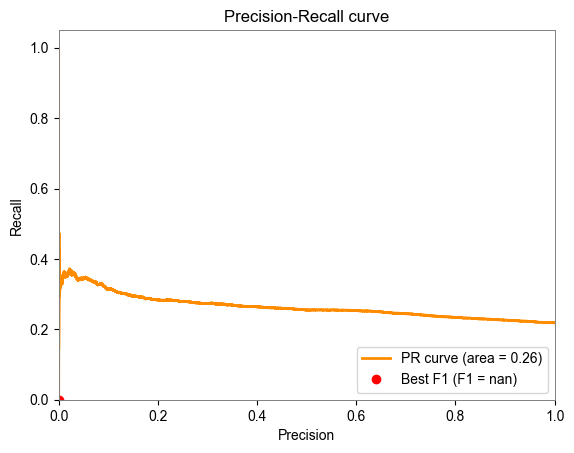

In [38]:
# plot precision recall curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
precision, recall, _ = precision_recall_curve(data["trg"], data["prb"])
average_precision = average_precision_score(data["trg"], data["prb"])

plt.figure()
lw = 2
plt.plot(recall, precision, color='darkorange',
         lw=lw, label='PR curve (area = %0.2f)' % average_precision)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall curve')
plt.legend(loc="lower right")

# Calculate F1 score at different points on the curve
f1_scores = 2 * (precision * recall) / (precision + recall)
best_index = np.argmax(f1_scores)
best_f1 = f1_scores[best_index]

plt.plot(recall[best_index], precision[best_index], 'ro', label='Best F1 (F1 = %0.2f)' % best_f1)
plt.legend(loc="lower right")
plt.show()


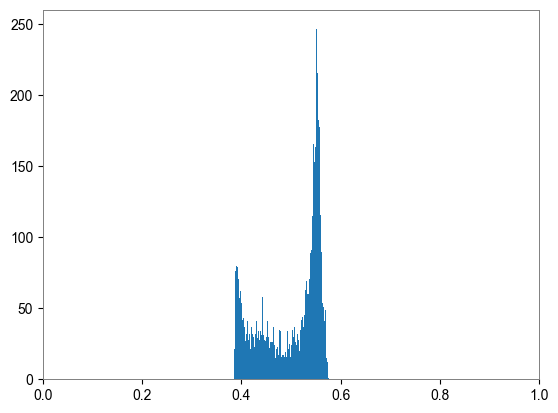

In [51]:
data = load_stats(moving_c2v)
plt.hist(data['prb'], bins=1000)
plt.xlim(0,1)
plt.show()

In [ ]:
len(data['prb'])


48685

In [113]:
data = {}

In [114]:
data["c2v"] = return_stats(moving_c2v)

/Users/nikolaibeckjensen/Company2Vec/myenv2/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


AUC is done: 0.26 s
0.5666110515594482
MCC is done: 14.17 s
{'mean': 0.08362317085266113, 'lower': 0.07436136212199926, 'upper': 0.09169389866292477}
ACC is done: 14.51 s
{'mean': 0.48138031363487244, 'lower': 0.4765934206545353, 'upper': 0.4855099156498909}
F1 is done: 14.33 s
{'mean': 0.3605743646621704, 'lower': 0.3558559164404869, 'upper': 0.3647651940584183}
Precision is done: 14.42 s
{'mean': 0.24682754278182983, 'lower': 0.24356957972049714, 'upper': 0.24960128478705884}
Recall is done: 14.36 s
{'mean': 0.6687646508216858, 'lower': 0.6590887904167175, 'upper': 0.6776890754699707}


In [ ]:
simple_baselines = True
if simple_baselines:
    np.random.seed(0)
    data["rnd"] = {"prb": np.random.uniform(size=data["rnn"]["trg"].shape[0]),
               "trg": data["rnn"]["trg"]}
    data["rnd"]["aul"] = return_aul(preds = data["rnd"]["prb"],  
                               targs = data["rnd"]["trg"])
    data["rnd"]["mcc"] = bootstrap_mcc(preds = torch.from_numpy(data["rnd"]["prb"]),  
              targs = torch.from_numpy(data["rnd"]["trg"]).long(), 
              n_bootstraps=1000,
              alpha = 0.025,
              beta=1.0)
    data["rnd"]["acc"] = bootstrap_acc(preds = torch.from_numpy(data["rnd"]["prb"]),  
              targs = torch.from_numpy(data["rnd"]["trg"]).long(), 
              n_bootstraps=1000,
              alpha = 0.025,
              beta=1.0)
    data["rnd"]["f1"] = bootstrap_f1(preds = torch.from_numpy(data["rnd"]["prb"]),  
              targs = torch.from_numpy(data["rnd"]["trg"]).long(), 
              n_bootstraps=1000,
              alpha = 0.025,
              beta=1.0)


In [ ]:
np.random.seed(0)
data["mjr"] = {"prb": np.random.uniform(high=0.5, size=data["rnn"]["trg"].shape[0]),
               "trg": data["rnn"]["trg"]}
data["mjr"]["aul"] = return_aul(preds = data["mjr"]["prb"],  
                               targs = data["mjr"]["trg"])
data["mjr"]["mcc"] = {"mean": return_mcc(preds = torch.from_numpy(data["mjr"]["prb"]),  
                               targs = torch.from_numpy(data["mjr"]["trg"]).long()), "lower": np.nan, "upper": np.nan}
data["mjr"]["acc"] = {"mean": return_acc(preds = torch.from_numpy(data["mjr"]["prb"]),  
                               targs = torch.from_numpy(data["mjr"]["trg"]).long()), "lower": np.nan, "upper": np.nan}
data["mjr"]["f1"] = {"mean": return_f1(preds = torch.from_numpy(data["mjr"]["prb"]),  
                               targs = torch.from_numpy(data["mjr"]["trg"]).long()), "lower": np.nan, "upper": np.nan}

In [ ]:
try:
    raise Error() 
    with open(save_path + "metric.pkl", "wb") as f:
        pickle.dump(data,f)
except:
    with open(save_path + "metric.pkl", "rb") as f:
        data = pickle.load(f)

In [ ]:
print("AUL")
for key in data.keys():
    print("\t%s: %.3f [%.3f, %.3f]" %(key, data[key]["aul"]["mean"], 
                                           data[key]["aul"]["lower"], 
                                           data[key]["aul"]["upper"]))
print("MCC")
for key in data.keys():
    print("\t%s: %.3f [%.3f, %.3f]" %(key, data[key]["mcc"]["mean"], 
                                           data[key]["mcc"]["lower"], 
                                           data[key]["mcc"]["upper"]))
print("ACC")
for key in data.keys():
    print("\t%s: %.3f [%.3f, %.3f]" %(key, data[key]["acc"]["mean"], 
                                           data[key]["acc"]["lower"], 
                                           data[key]["acc"]["upper"]))
print("F1")
for key in data.keys():
    print("\t%s: %.3f [%.3f, %.3f]" %(key, data[key]["f1"]["mean"], 
                                           data[key]["f1"]["lower"], 
                                           data[key]["f1"]["upper"]))

## 1. Breakdown by subsets

In [115]:
def get_employee_counts(test_cvrs, _period_start='2022-01-01' ) -> list:
    """ Returns a list of CVRs that satisfy the employee filter """
    _period_start = pd.to_datetime(_period_start)

    # get the financials data 
    employee_path = DATA_ROOT / "Tables" / "EmployeeCounts"
    employees_csv = [file for file in employee_path.iterdir() if file.is_file() and file.suffix == '.csv']
    df_employees = dd.read_csv(
        employees_csv,
        usecols=['CVR', 'FromDate', 'EmployeeCounts'],
        on_bad_lines="error",
        assume_missing=True,
        dtype={
                "CVR": int,
                "FromDate": str,
                "EmployeeCounts": float,
            },
        blocksize="256MB"
    ).compute()

    # apply filters on the annual reports in the year up until the cutoff date, take the most recent employee entry
    df_employees['FromDate'] = pd.to_datetime(df_employees['FromDate'], errors='coerce')
    df_employees = df_employees.loc[(df_employees.FromDate < _period_start) & (df_employees.FromDate >= _period_start - pd.DateOffset(years=1))]
    df_employees = df_employees.sort_values(by=['CVR', 'FromDate'], ascending=False).drop_duplicates(subset='CVR', keep='first')
    
    df = pd.DataFrame({'CVR': test_cvrs})
    df = df.merge(df_employees, on='CVR', how='left').fillna(0)

    return df.drop(columns=['FromDate']).set_index("CVR")

def discrete_employee(x):
    if x == 0:
        return "[0]"
    elif x <= 1:
        return "]0, 1]"
    elif x <= 10:
        return "]1, 10]"
    else:
        return ">10"
    

In [116]:
counts = get_employee_counts(test_cvrs=data['c2v']['id'], _period_start='2022-01-01' ) 

In [117]:
data_split = r'/Users/nikolaibeckjensen/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Virk2Vec/data/processed/populations/bankruptcy/data_split/result.pkl'
df = pd.read_pickle(data_split)

idx_test = df.test
idx_preds = data['id']

print("Length of test set: %i" %len(idx_test))
print("Length of prediction set: %i" %len(idx_preds))

# how many of the predictions are in the test set
print(len(set(idx_test).intersection(set(idx_preds)))/len(idx_preds))

_sum = 0
for cvr in idx_test:
    if cvr in idx_preds:
        _sum += 1
print("share of test set in predictions: %.2f" %(_sum/len(idx_test)))

i = 0
# print 10 CVRS that are not in the test set
for idx, cvr in enumerate(idx_preds):
    i += 1
    if cvr not in idx_test and i > 39990:
        print(cvr, idx_test[idx])
        
    if i == 40000:
        break
        


KeyError: 'id'

In [ ]:
# SEQUENCE LENGTH
# with open(r"..\\cls\\eos_l2v\\%s\\" %v + "seqlen.pkl", "rb") as f:
#     counts = pickle.load(f)
#     counts = pd.DataFrame.from_dict(counts, orient="index")
#     counts.index = counts.index.rename("PERSON_ID")
#     counts = counts.rename(columns={0: "SEQLEN"})
#     counts["SEQLEN"] = counts["SEQLEN"].apply(lambda x: np.minimum(x, 2560))

# with open(r"..\\cls\\eos_l2v\\%s\\" %v + "has_health.pkl", "rb") as f:
#     has_health = pickle.load(f)
#     has_health = pd.DataFrame.from_dict(has_health, orient="index")
#     has_health.index = has_health.index.rename("PERSON_ID")
#     has_health = has_health.rename(columns={0: "HAS_HEALTH"})



In [124]:
population_path = DATA_ROOT / "processed" / "populations" / "moving" / "population" / "result.pkl"
ppl = pd.read_pickle(population_path)
result = pd.DataFrame({"CVR": data["c2v"]["id"].astype(int),
                        "PRED": data["c2v"]["prb"]}).set_index("CVR")
result = result.join(ppl, how="left")
result = result.join(counts, how="left")

# ec_q = np.quantile(result["SEQLEN"].values, [0, 0.33, 0.66, 1.])
# result["SEQLEN"] = pd.cut(result["SEQLEN"], bins = ec_q,
#                                include_lowest=True, labels=False)
result["EMPLOYEES"] = result["EmployeeCounts"].apply(lambda x: discrete_employee(x))
#result["UNLABELED"] = result.apply(lambda x: (x["TARGET"] == 0) & (x["EVENT_FINAL_DATE"] < pd.to_datetime("2020-12-31", format="%Y-%m-%d")), axis = 1)
#result["YEAR"] = result["EVENT_FINAL_DATE"].dt.year

In [130]:
population_path = DATA_ROOT / "processed" / "populations" / "moving_min_emp" / "population" / "result.pkl"
ppl = pd.read_pickle(population_path)

In [134]:
ppl.TARGET.value_counts(normalize=True)

0    0.76577
1    0.23423
Name: TARGET, dtype: float64

In [125]:
result

,PRED,FROM_DATE,CURRENT_ASSETS,CASH_AND_CASH_EQUIVALENTS,SHORT_TERM_LIABILITIES,FOUNDING_DATE,TARGET,EmployeeCounts,EMPLOYEES
CVR,,,,,,,,,
10000459,0.391278,2014-04-15,1676221.0,1382865.0,43367402.0,1999-10-15,1,0.0,[0]
10001323,0.388885,2017-02-20,1133727.0,256841.0,1057192.0,1999-10-08,0,0.0,[0]
10002028,0.494151,2015-03-31,5110.0,NaN,836746.0,1973-06-29,0,0.0,[0]
10002699,0.412101,2015-04-27,1524453.0,0.0,204554.0,1985-11-08,0,0.0,[0]
10003156,0.392127,2014-10-01,4625.0,4625.0,12000.0,1999-10-15,1,0.0,[0]
...,...,...,...,...,...,...,...,...,...
89940214,0.440045,2015-12-21,3949064.0,85634.0,233075.0,1982-03-01,1,0.0,[0]
89956528,0.429055,2015-05-27,544208.0,2340.0,632472.0,1982-03-12,0,2.0,"]1, 10]"
89988314,0.420380,2015-02-26,87354.0,57055.0,204711.0,1982-04-02,0,0.0,[0]


In [ ]:

# YEAR PREDICTION RESULTS
# def bootstrap_simple(x, n_samples = 1000):
#     N = x.shape[0]
#     out = list()
#     for i in range(n_samples):
#         _id = np.random.choice(N, size=N, replace=True)
#         tp = x[_id].sum()
#         out.append(tp/N)
#     return out, N, 
        
        
# py_label = [2022, 2023]
# py_recall = list()
# py_n_tp = list()
# py_n_total = list()
# for i in py_label:
#     r = result[(result["YEAR"]== (i)) & (result["TARGET"] == 1)]
#     y_hat = np.array((r["PRED"].values > 0.5)).astype(int)
#     _recall, _n = bootstrap_simple(y_hat)
#     py_recall.append((np.mean(_recall), np.std(_recall)))
#     py_n_tp.append(y_hat.sum())
#     py_n_total.append(_n)

# fig, ax = plt.subplots(1,2, figsize=(10,6))
# mu = [i for i, _ in py_recall]
# std = [i for _, i in py_recall]
# ax[0].bar(x=py_label, height=mu, xerr=std, width=0.5)
# ax[0].set_xlabel("Year of death")
# ax[0].set_ylabel("Fraction of correctly identified deceased people")
# ax[0].set_title("Recall for deceased people")
# ax[0].set_ylim([0, 1.])
# ax[0].tick_params(axis= "x", which="major", width= 1, length = 6, direction="out", color="gray")
# ax[0].tick_params(axis= "y", which="minor", width= 1, length = 3, direction="out", color="gray")
# ax[0].yaxis.set_major_locator(MultipleLocator(0.1))
# ax[0].yaxis.set_minor_locator(AutoMinorLocator(5))
# ax[0].xaxis.set_major_locator(MultipleLocator(1))

# ax[1].bar(x=[i-0.17 for i in py_label], height=py_n_total, width=0.3, label="Total")
# ax[1].bar(x=[i+ 0.17 for i in py_label], height=py_n_tp, width=0.3, label = "True Positive")
# ax[1].legend()
# ax[1].set_xlabel("Year of death")
# ax[1].set_ylabel("Fraction of correctly identified deceased people")
# ax[1].set_title("Predictions for deceased people")
# # ax[1].set_ylim([0, 1.])
# ax[1].tick_params(axis= "x", which="major", width= 1, length = 6, direction="out", color="gray")
# ax[1].tick_params(axis= "y", which="minor", width= 1, length = 3, direction="out", color="gray")
# ax[1].xaxis.set_major_locator(MultipleLocator(1))
# ax[1].yaxis.set_minor_locator(AutoMinorLocator(5))
# sns.despine()
# plt.tight_layout()
# plt.savefig(save_path + "yearly_mortality_performance.svg", format="svg")
# plt.show()

In [126]:
groups = {
          "[0]": result["EMPLOYEES"] == "[0]",
          "]0, 1]": result["EMPLOYEES"] == "]0, 1]",
          "]1, 10]": result["EMPLOYEES"] == "]1, 10]",
          ">10": result["EMPLOYEES"] == ">10"
            }

["[0]", ']0, 1]', ']1, 10]' '>10']

['[0]', ']0, 1]', ']1, 10]>10']

In [127]:
unitary_mcc = {}
unitary_prb = {}
unitary_cnt = {}

for k, condition in groups.items():
    preds = result[condition]["PRED"].values
    targs = result[condition]["TARGET"].values
    unitary_mcc[k] = bootstrap_mcc(torch.from_numpy(preds).float(), torch.from_numpy(targs.to_numpy()).long())
    unitary_prb[k] = {"median": np.median(preds), "mad": mad(preds)}
    unitary_cnt[k] = {"total": preds.shape[0], "positive": np.sum(targs.to_numpy())}
    print("Done:", k)

Done: [0]
Done: ]0, 1]
Done: ]1, 10]
Done: >10


In [128]:
def return_stats(labels, prb_dict, count_dict,  mcc_dict, title:str, figsize=(10,10)):
    mu, var, err = [], [], []
    padding = 0.5

    for label in labels:
        mu.append(prb_dict[label]["median"])
        var.append(prb_dict[label]["mad"])
        err.append([mu[-1] - var[-1], mu[-1] + var[-1]])
    
    fig, ax = plt.subplots(2,2, figsize=figsize)

    #### MEDIAN PRB
    ax[0,0].errorbar(y = labels, x = mu, xerr = var, fmt="o",
                     capsize=5, ecolor="dimgray", ms=3.5,
                     elinewidth=2, mfc="black", mec="black")
    
    ax[0,0].set_xlabel("Median Probability of Death")
    ax[0,0].set_ylabel("%s" %title)
    ax[0,0].set_title("Median Probability of Death per %s" %title)

    ax[0,0].tick_params(axis= "x", which="major", width= 1, length = 6, direction="out", color="gray")
    ax[0,0].tick_params(axis= "x", which="minor", width= 1, length = 3, direction="out", color="gray")
    ax[0,0].tick_params(axis= "y", which="both", width=0, length =0)

    ax[0,0].xaxis.set_major_locator(MultipleLocator(0.1))
    ax[0,0].xaxis.set_minor_locator(AutoMinorLocator(5))
    ax[0,0].set_ylim(-padding, len(labels) - 1 + padding)
    ax[0,0].set_xlim([0, 1.])
    #### POSITIVE COUNT
    count = list()
    for label in labels:
        count.append(count_dict[label]["positive"])

    ax[0,1].barh(y = labels, height = 0.5,  
        width=count,  edgecolor="none", facecolor="silver")
    ax[0,1].set_xlabel("Number of Deceased")
    ax[0,1].set_ylabel("%s" %title)
    ax[0,1].set_title("Number of Deceased People per %s" %title)

    ax[0,1].tick_params(axis= "x", which="major", width= 1, length = 6, direction="out", color="gray")
    ax[0,1].tick_params(axis= "x", which="minor", width= 1, length = 3, direction="out", color="gray")
    ax[0,1].tick_params(axis= "y", which="both", width=0, length =0)

    ax[0,1].xaxis.set_major_locator(MultipleLocator(500))
    ax[0,1].xaxis.set_minor_locator(AutoMinorLocator(5))

    ### POPULATION COUNTS
    count = list()
    for label in labels:
        count.append(count_dict[label]["total"])
    ax[1,0].barh(y = labels, height = 0.5, label = "alive",  width=count, facecolor="silver", edgecolor="none")
    count = list()
    for label in labels:
        count.append(count_dict[label]["positive"]) #+ count_dict[label]["unlabeled"])
    
    #ax[1,0].barh(y = labels, height = 0.5, label= "unlabeled",  width=count, facecolor="orange", edgecolor="none")
    count = list()
    for label in labels:
        count.append(count_dict[label]["positive"])
    ax[1,0].barh(y = labels, height = 0.5, label= "deceased",  width=count, facecolor="dimgray", edgecolor="none")


    ax[1,0].set_xlabel("Number of People")
    ax[1,0].set_ylabel("%s" %title)
    ax[1,0].set_title("Number of People per %s" %title)
    ax[1,0].tick_params(axis= "x", which="major", width=1, length = 6, direction="out", color="gray")
    ax[1,0].tick_params(axis= "x", which="minor", width=1, length =3, direction="out", color="gray")
    ax[1,0].tick_params(axis= "y", which="both", width=0, length =0)
    xlim = np.max([ax[1,0].get_xlim()[1], 10100])
    ax[1,0].set_xlim([0, xlim])
    if xlim < 35000:
        ax[1,0].xaxis.set_major_locator(MultipleLocator(5000))
    else:
        ax[1,0].xaxis.set_major_locator(MultipleLocator(15000))

    ax[1,0].xaxis.set_minor_locator(AutoMinorLocator(5))
    ax[1,0].legend()
    
    mu, var, err = [], [], []

    for label in labels:
        mu.append(mcc_dict[label]["mean"])
        var.append(mcc_dict[label]["upper"])
        err.append([np.abs(mu[-1] - mcc_dict[label]["lower"]), np.abs(mu[-1] - mcc_dict[label]["upper"])])
        

    ax[1,1].errorbar(y = labels,  
        xerr= np.array(err).T, x= mu, fmt="o",
                     capsize=5, ecolor="dimgray", ms=3.5,
                     elinewidth=2, mfc="black", mec="black")
    ax[1,1].set_xlabel("MCC Score")
    ax[1,1].set_ylabel("%s" %title)
    ax[1,1].set_title("MCC per %s" %title)
    xlim = np.max([np.max(var) + 0.05, 0.8])
    ax[1,1].set_xlim([-0.1, xlim])
    ax[1,1].set_ylim([-padding, len(labels)-1+padding])
    ax[1,1].axvline(0.0, color="gray", linewidth=0.5, linestyle= ":")
    ax[1,1].axvline(0.413, color="blue", linewidth=1, linestyle= ":")


    ax[1,1].tick_params(axis= "x", which="major", width=1, length = 6, direction="out", color="gray")
    ax[1,1].tick_params(axis= "x", which="minor", width=1, length =3, direction="out", color="gray")
    ax[1,1].tick_params(axis= "y", which="both", width=0, length =0)

    ax[1,1].xaxis.set_major_locator(MultipleLocator(0.1))
    ax[1,1].xaxis.set_minor_locator(AutoMinorLocator(5))
    return fig

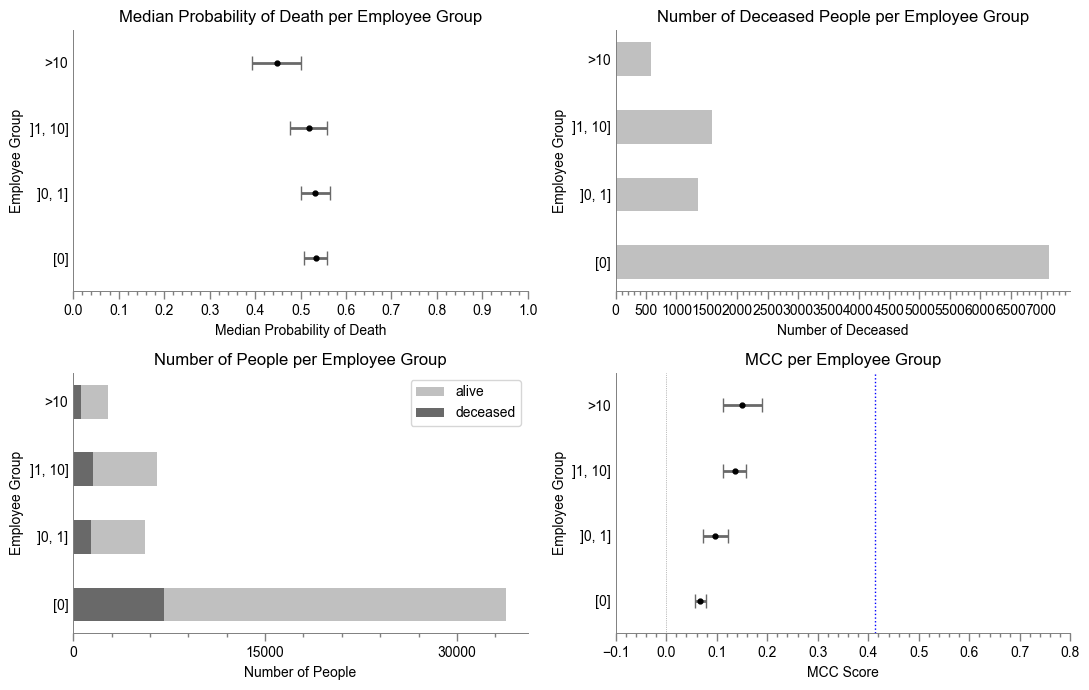

In [129]:
labels = ["[0]", ']0, 1]', ']1, 10]', '>10']
group_title = "Employee Group"
return_stats(labels, unitary_prb, unitary_cnt, unitary_mcc, group_title, figsize=(11,7))
sns.despine()
plt.tight_layout()
#plt.savefig(save_path + "mortality_age.svg", format="svg")
plt.show()

In [ ]:
labels = ['[0]', '[1,5)', '[5,11)', '[11,19)', '>=19']
group_title = "Health Group"
return_stats(labels, unitary_prb, unitary_cnt, unitary_mcc, group_title, figsize=(11,5))
sns.despine()
plt.tight_layout()
plt.savefig(save_path + "mortality_health_events.svg", format="svg")
plt.show()

In [ ]:
labels = [ '[48, 921)', '[921, 1176)', '[1176, 2560]']
group_title = "Sequence Len Group"
return_stats(labels, unitary_prb, unitary_cnt, unitary_mcc, group_title, figsize=(11,4))
sns.despine()
plt.tight_layout()
plt.savefig(save_path + "mortality_seqlen.svg", format="svg")
plt.show()

In [ ]:
labels = ['(34,39]', '(39, 44]', '(44, 49]', '(49, 54]', '(54, 59]', '(59, 64]']
group_title = "Age Group"
return_stats(labels, unitary_prb, unitary_cnt, unitary_mcc, group_title, figsize=(11,7))
sns.despine()
plt.tight_layout()
plt.savefig(save_path + "mortality_age.svg", format="svg")
plt.show()

In [ ]:
labels = ["male", "female", "DK", "NON-DK"]
group_title = "Unitary (Subset) Groups"
return_stats(labels, unitary_prb, unitary_cnt, unitary_mcc, group_title, figsize=(11,5))
sns.despine()
plt.tight_layout()
plt.savefig(save_path + "mortality_unitary.svg", format="svg")
plt.show()

In [ ]:
labels = ['male', 'female', '(34,39]', '(39, 44]', '(44, 49]', '(49, 54]', '(54, 59]', '(59, 64]', 'DK', 'NON-DK']
group_title = "Unitary (All) Groups"
return_stats(labels, unitary_prb, unitary_cnt, unitary_mcc, group_title, figsize=(11,11))
sns.despine()
plt.tight_layout()
plt.savefig(save_path + "mortality_unitary_full.svg", format="svg")
plt.show()

In [ ]:
intersect_groups = dict()

for l1 in ['(34,39]', '(39, 44]', '(44, 49]', '(49, 54]', '(54, 59]', '(59, 64]']:
    for l2 in ["male", "female"]:
        intersect_groups[" ".join([l1,l2])] = (groups[l1]) & (groups[l2])

intersec_mcc = {}
intersec_prb = {}
intersec_cnt = {}

for k, condition in intersect_groups.items():
    preds = result[condition]["PRED"].values
    targs = result[condition]["TARGET"].values
    intersec_mcc[k] = bootstrap_mcc(torch.from_numpy(preds).float(), torch.from_numpy(targs).long())
    intersec_prb[k] = {"median": np.median(preds), "mad": mad(preds)}
    intersec_cnt[k] = {"total": preds.shape[0], "positive": np.sum(targs), "unlabeled": result[condition]["UNLABELED"].values.sum()}
    print("Done:", k)


In [ ]:
labels = list(intersect_groups.keys())
group_title = "Intersectional (All) Groups"
return_stats(labels, intersec_prb, intersec_cnt, intersec_mcc, group_title, figsize=(11,13))
sns.despine()
plt.tight_layout()
plt.savefig(save_path + "mortality_intersect_age_sex.svg", format="svg")
plt.show()

In [ ]:
intersect_groups = dict()

for l1 in ['[0]', '(0,3)', '[3,9)', '>9']:
    for l2 in ["male", "female"]:
        intersect_groups[" ".join([l1,l2])] = (groups[l1]) & (groups[l2])

intersec_mcc = {}
intersec_prb = {}
intersec_cnt = {}

for k, condition in intersect_groups.items():
    preds = result[condition]["PRED"].values
    targs = result[condition]["TARGET"].values
    intersec_mcc[k] = bootstrap_mcc(torch.from_numpy(preds).float(), torch.from_numpy(targs).long())
    intersec_prb[k] = {"median": np.median(preds), "mad": mad(preds)}
    intersec_cnt[k] = {"total": preds.shape[0], "positive": np.sum(targs), "unlabeled": result[condition]["UNLABELED"].values.sum()}
    print("Done:", k)

In [ ]:
labels = list(intersect_groups.keys())
group_title = "Intersectional (Subset) Groups"
return_stats(labels, intersec_prb, intersec_cnt, intersec_mcc, group_title, figsize=(11,9))
sns.despine()
plt.tight_layout()
plt.savefig(save_path + "mortality_intersect_sex_health.svg", format="svg")
plt.show()

In [ ]:
intersect_groups = dict()

for l1 in ['[48, 921)', '[921, 1176)', '[1176, 2560]']:
    for l2 in ["male", "female"]:
        intersect_groups[" ".join([l1,l2])] = (groups[l1]) & (groups[l2])

intersec_mcc = {}
intersec_prb = {}
intersec_cnt = {}

for k, condition in intersect_groups.items():
    preds = result[condition]["PRED"].values
    targs = result[condition]["TARGET"].values
    intersec_mcc[k] = bootstrap_mcc(torch.from_numpy(preds).float(), torch.from_numpy(targs).long())
    intersec_prb[k] = {"median": np.median(preds), "mad": mad(preds)}
    intersec_cnt[k] = {"total": preds.shape[0], "positive": np.sum(targs), "unlabeled": result[condition]["UNLABELED"].values.sum()}
    print("Done:", k)
    

In [ ]:
labels = list(intersect_groups.keys())
group_title = "Intersectional (Subset) Groups"
return_stats(labels, intersec_prb, intersec_cnt, intersec_mcc, group_title, figsize=(11,7))
sns.despine()
plt.tight_layout()
plt.savefig(save_path + "mortality_intersect_sex_length.svg", format="svg")
plt.show()